In [1]:
# read the data and do K means over the partitions

In [2]:
# consider running zscore values

In [3]:
import pandas, seaborn, os, numpy

import sklearn, sklearn.cluster
import scipy, scipy.stats

In [4]:
%matplotlib inline
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(8, 4), 'axes.labelsize':20})

# 0. user-defined variables

In [5]:
#! drangajokull
home_dir = '/home/adrian/'

#! necio5
#home_dir = '/Users/adrian/'

In [6]:
full_wound_metabolic_file = '/home/adrian/gd15/hi/research/kerecis/data/clusters/df_logFC_comb_FULL.csv'
partial_wound_metabolic_file = '/home/adrian/gd15/hi/research/kerecis/data/clusters/df_logFC_comb_partial.csv'
scratch_dir = home_dir + 'scratch/'

In [7]:
days = [7, 14, 21, 28, 60]

# 1. read data

In [8]:
profiles = pandas.read_csv(full_wound_metabolic_file, index_col=0)

print(profiles.shape)
profiles.head()

(244, 5)


,logFC07,logFC14,logFC21,logFC28,logFC60
mz,,,,,
60.0452_pos,-0.083854,0.191472,0.982798,0.988894,0.743300
60.05658_pos,-0.038624,0.089157,0.781340,0.774211,0.811386
62.02452_pos,1.505635,1.319179,1.076527,1.081010,0.233993
71.02976_pos,1.279493,0.952287,0.857605,0.819389,0.030744
73.53242_pos,1.519172,1.332466,1.114554,1.120287,0.153851


In [ ]:
a = profiles.max(axis=1).to_list()
b = profiles.min(axis=1).to_list()
for i in range(len(a)):
    diff = abs(a[i] - b[i])
    if diff < numpy.log2(1.75):
        print(a[i], b[i], diff)

In [9]:
zscore_profiles = pandas.DataFrame(scipy.stats.zscore(profiles, axis=1), index=profiles.index)

print(zscore_profiles.shape)
zscore_profiles.head()

(244, 5)


,0,1,2,3,4
mz,,,,,
60.0452_pos,-1.490173,-0.857387,0.961330,0.975340,0.410889
60.05658_pos,-1.386680,-1.047310,0.791042,0.772108,0.870840
62.02452_pos,1.062214,0.633861,0.076405,0.086705,-1.859184
71.02976_pos,1.193809,0.399200,0.169268,0.076462,-1.838739
73.53242_pos,0.998931,0.603039,0.140981,0.153138,-1.896089


In [10]:
print(zscore_profiles.iloc[2, :])
print(numpy.mean(zscore_profiles.iloc[2, :]))
print(numpy.std(zscore_profiles.iloc[2, :]))

0    1.062214
1    0.633861
2    0.076405
3    0.086705
4   -1.859184
Name: 62.02452_pos, dtype: float64
-2.6645352591003756e-16
1.0


# 2. visualization and formatting

In [11]:
print(zscore_profiles.max())
print(zscore_profiles.min())

0    1.959745
1    1.435840
2    1.811548
3    1.657814
4    1.259948
dtype: float64
0   -1.963852
1   -1.393099
2   -0.573176
3   -1.074903
4   -1.997137
dtype: float64


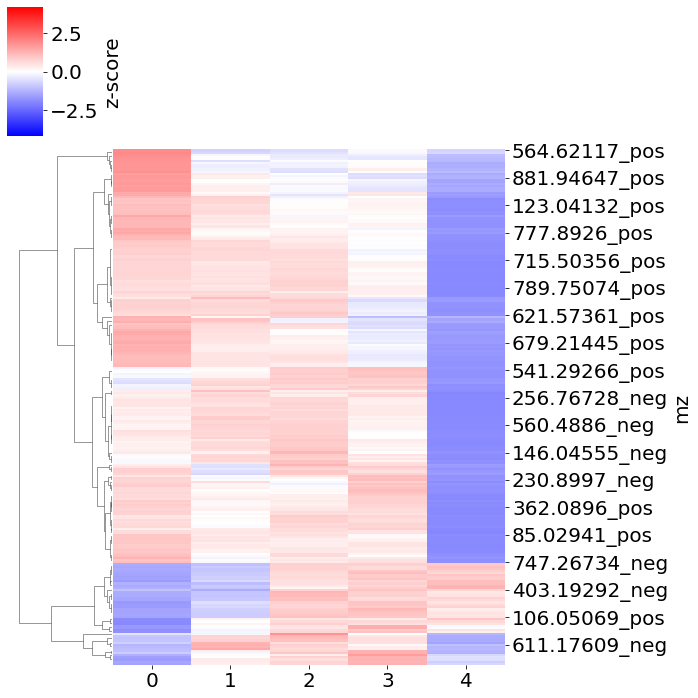

In [12]:
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.clustermap(zscore_profiles, cmap='bwr', vmin=-4.25, vmax=4.25, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'z-score'})

In [13]:
x = zscore_profiles.to_numpy()
x

array([[-1.49017261, -0.85738675,  0.96132976,  0.97534024,  0.41088936],
       [-1.38668006, -1.04730988,  0.79104184,  0.77210809,  0.87084001],
       [ 1.06221391,  0.63386085,  0.07640512,  0.08670453, -1.8591844 ],
       ...,
       [ 0.64885422, -0.08319587,  0.66505973,  0.68318412, -1.91390221],
       [ 0.24492994,  0.62758681,  0.8596667 ,  0.20789327, -1.94007672],
       [ 0.52089942,  0.49519326,  0.68939048,  0.27726987, -1.98275304]])

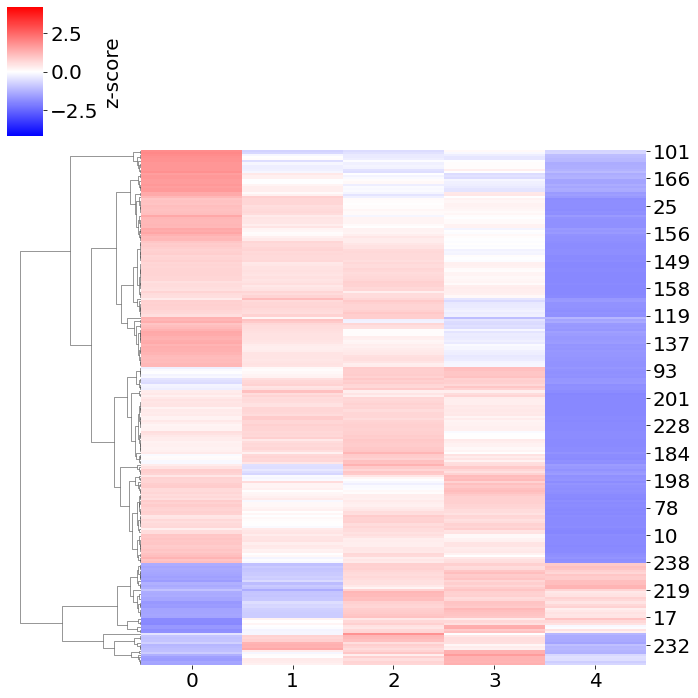

In [14]:
seaborn.clustermap(x, cmap='bwr', vmin=-4.25, vmax=4.25, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'z-score'})

# 3. analysis

In [15]:
number_elements = zscore_profiles.shape[0]
print('number of elements {}'.format(number_elements))
fine = int(number_elements/5)
coarse = int(number_elements/20)
print(coarse, fine)
k_range = range(coarse, fine+1)

k_range = range(2, 8)
print(k_range)
k_range = range(2, 20)
print(k_range)

number of elements 244
12 48
range(2, 8)
range(2, 20)


In [16]:
p_ss = []; p_khi = []; p_dbi = [];

for k in k_range:
    

    partition = sklearn.cluster.AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='complete').fit(x)
    labels = partition.labels_

    ss = sklearn.metrics.silhouette_score(x, labels, metric='cosine')
    khi = sklearn.metrics.calinski_harabasz_score(x, labels)
    dbi = sklearn.metrics.davies_bouldin_score(x, labels)

    print(ss, khi, dbi)
    
    p_ss.append(ss)
    p_khi.append(khi)
    p_dbi.append(dbi)
    
    ###
    ### generate plot of cluster dynamics
    ###
    figures_dir = scratch_dir + str(k) + '/'
    if os.path.exists(figures_dir) == False:
        os.mkdir(figures_dir)
        
    for clusterID in range(k):
        
        indices = numpy.where(labels == clusterID)[0]
        print('\nCluster c{} with {} gene indices: {}\n'.format(clusterID, len(indices), indices))
        cluster = zscore_profiles.iloc[indices, :]
        
        for metabolite in cluster.index:
            matplotlib.pyplot.plot(days, cluster.loc[metabolite, :], '-', alpha=1/2, lw=3)
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('z-score')
        matplotlib.pyplot.grid(alpha=0.5, ls=':')
        #matplotlib.pyplot.ylim([-4.25, 4.25])
        matplotlib.pyplot.xlim(([6, 61]))
        matplotlib.pyplot.title('k = {} | c{} | n = {}'.format(k, clusterID, len(indices)))
        matplotlib.pyplot.tight_layout()
        matplotlib.pyplot.savefig(figures_dir+'c{}.pdf'.format(clusterID))
        matplotlib.pyplot.clf()
        

0.8180859198848907 397.81037711640175 0.6263855489775245

Cluster c0 with 48 gene indices: [  0   1  11  12  13  14  15  17  19  20  21  22  28  35  37  39  42  43
  51  55  56  57  72  73  85  86  87  92 116 167 168 169 175 177 180 186
 187 188 191 192 194 200 207 208 210 219 225 232]


Cluster c1 with 196 gene indices: [  2   3   4   5   6   7   8   9  10  16  18  23  24  25  26  27  29  30
  31  32  33  34  36  38  40  41  44  45  46  47  48  49  50  52  53  54
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  74  75  76  77
  78  79  80  81  82  83  84  88  89  90  91  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 170 171 172 173 174 176
 178 179 181 182 183 184 185 189 190 193 195 196 197 198 199 201 202 203
 204 205 206 209 211


Cluster c6 with 46 gene indices: [ 23  24  36  38  41  44  53  54  60  61  62  66  67  70  89  91  93  94
  95  96 109 115 121 152 157 170 171 172 173 178 179 184 201 202 214 220
 221 222 223 224 227 228 234 236 239 242]


Cluster c7 with 7 gene indices: [ 28  51  55 194 200 207 232]

0.40995655051857904 224.78878118041388 0.8848452350085011

Cluster c0 with 33 gene indices: [  0   1  11  12  13  14  15  17  19  20  21  22  35  37  39  42  43  57
  72  73  85  86  87  92 175 186 187 188 191 192 210 219 225]


Cluster c1 with 47 gene indices: [  9  10  26  29  31  34  45  46  65  69  71  74  75  78  79  81  84 131
 144 174 176 182 183 185 189 190 193 196 198 199 205 206 209 211 212 213
 216 217 218 229 230 231 233 237 238 240 241]


Cluster c2 with 60 gene indices: [  7   8  27  30  33  48  52  63  64  68  76  77  83  88 102 103 104 110
 111 112 113 114 117 118 119 120 122 123 124 125 127 128 132 133 134 135
 136 137 139 145 146 147 148 149 150 151 153 158 159 160 161 162 163 164
 165 


Cluster c4 with 35 gene indices: [ 23  24  36  38  53  54  60  61  62  66  70  89  91 109 115 121 152 157
 173 178 179 184 201 202 220 221 222 223 224 227 228 234 236 239 242]


Cluster c5 with 36 gene indices: [  7  33  88 102 103 104 110 114 117 118 119 120 122 123 127 128 132 133
 134 135 147 148 149 150 151 158 159 160 161 162 163 164 165 226 235 243]


Cluster c6 with 4 gene indices: [11 19 72 73]


Cluster c7 with 7 gene indices: [ 28  51  55 194 200 207 232]


Cluster c8 with 11 gene indices: [ 49  97  98  99 100 101 129 130 140 141 143]


Cluster c9 with 7 gene indices: [116 167 168 169 177 180 208]


Cluster c10 with 5 gene indices: [205 216 231 233 240]


Cluster c11 with 1 gene indices: [56]


Cluster c12 with 11 gene indices: [ 41  44  67  93  94  95  96 170 171 172 214]


Cluster c13 with 3 gene indices: [ 87 188 192]

0.4210926163935318 217.67656325765603 0.8921143195253972

Cluster c0 with 42 gene indices: [  9  10  26  29  31  34  45  46  65  69  71  74  75  78  79  81


Cluster c9 with 23 gene indices: [  2   3   4   5   6  16  18  25  32  40  47  50  59  90 108 126 138 142
 156 181 195 197 215]


Cluster c10 with 5 gene indices: [205 216 231 233 240]


Cluster c11 with 1 gene indices: [56]


Cluster c12 with 11 gene indices: [ 41  44  67  93  94  95  96 170 171 172 214]


Cluster c13 with 3 gene indices: [ 87 188 192]


Cluster c14 with 1 gene indices: [63]


Cluster c15 with 9 gene indices: [ 65 174 176 182 190 198 206 217 218]


Cluster c16 with 12 gene indices: [  1  14  15  22  42  43  57  85  92 191 210 225]


Cluster c17 with 9 gene indices: [ 58  80  82 105 106 107 154 155 166]


Cluster c18 with 3 gene indices: [ 54  91 152]



<Figure size 576x288 with 0 Axes>

# 4. plotting

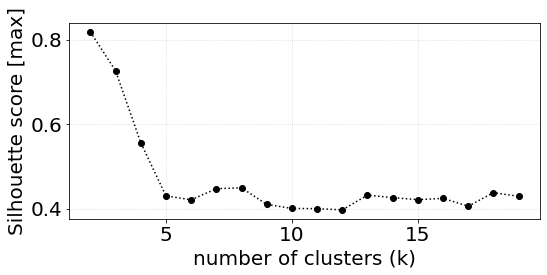

In [17]:
matplotlib.pyplot.plot(k_range, p_ss, 'ok')
matplotlib.pyplot.plot(k_range, p_ss, ':', color='black')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Silhouette score [max]')
matplotlib.pyplot.tight_layout()

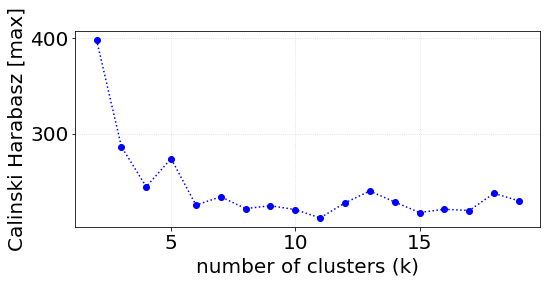

In [18]:
matplotlib.pyplot.plot(k_range, p_khi, 'ob')
matplotlib.pyplot.plot(k_range, p_khi, ':', color='blue')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Calinski Harabasz [max]')
matplotlib.pyplot.tight_layout()

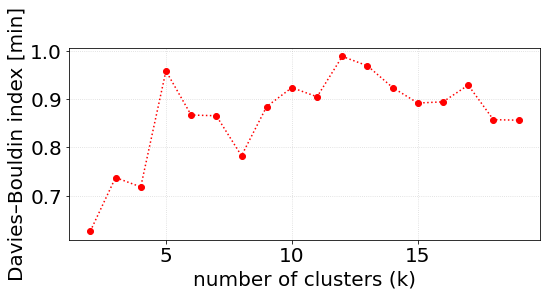

In [19]:
matplotlib.pyplot.plot(k_range, p_dbi, 'or')
matplotlib.pyplot.plot(k_range, p_dbi, ':', color='red')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Davies–Bouldin index [min]')
matplotlib.pyplot.tight_layout()
